In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
#%pip install seaborn

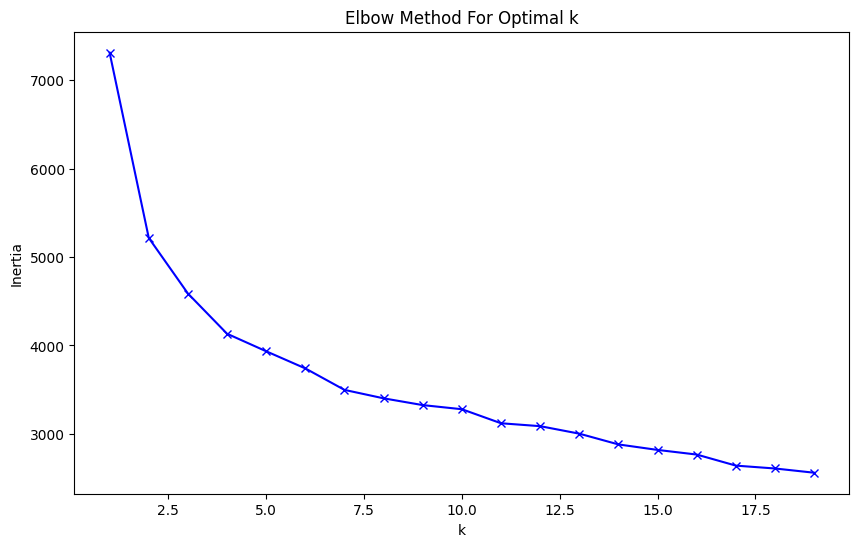

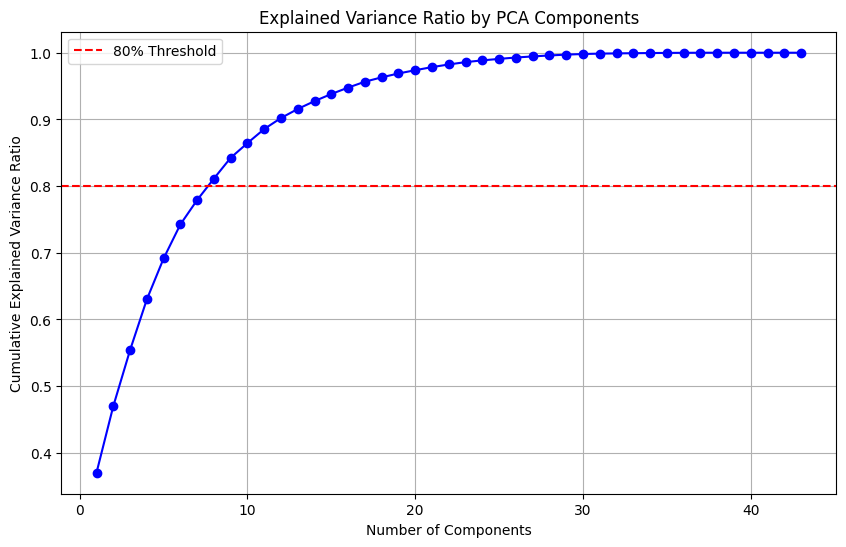

Number of components needed to explain 80% of variance: 8


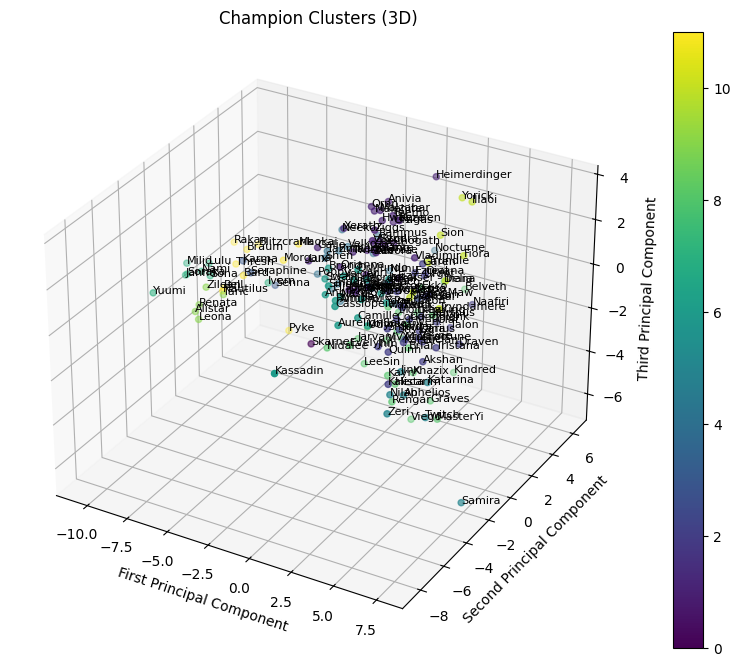


=== Cluster 0 ===

Champions in this cluster:
Sejuani, Skarner

Distinctive features:
damageSelfMitigated               49422.240
totalDamageTaken                  37917.790
damageDealtToObjectives           21604.845
totalDamageDealtToChampions       16865.840
physicalDamageDealtToChampions    10151.670
Name: 0, dtype: float64
--------------------------------------------------

=== Cluster 1 ===

Champions in this cluster:
Ahri, Akali, Anivia, Aurora, Azir, Chogath, Fizz, Galio, Gragas, Heimerdinger, Hwei, KSante, Kennen, Leblanc, Lissandra, Lux, Malphite, Malzahar, Mel, Orianna, Ornn, Ryze, Sylas, Syndra, Taliyah, Teemo, TwistedFate, Vex, Viktor, Vladimir, Xerath, Ziggs, Zoe

Distinctive features:
totalDamageTaken               22836.582727
totalDamageDealtToChampions    22433.235152
magicDamageDealtToChampions    19209.847879
damageSelfMitigated            16887.896061
goldEarned                     11030.481818
Name: 1, dtype: float64
----------------------------------------------

In [13]:
# Read the data
df = pd.read_csv('champion_stats.csv')

# Select features for clustering
features = [
    # Combat Stats
    'kills', 'deaths', 'assists', 'kda',
    'doubleKills', 'tripleKills', 'quadraKills', 'pentaKills',
    
    # Damage Stats
    'totalDamageDealtToChampions', 'totalDamageTaken',
    'magicDamageDealtToChampions', 'physicalDamageDealtToChampions', 'trueDamageDealtToChampions',
    'damageSelfMitigated', 'damage_per_minute',
    'largestCriticalStrike',
    
    # Support/Utility Stats
    'timeCCingOthers', 'totalHealsOnTeammates', 'totalDamageShieldedOnTeammates',
    
    # Economy Stats
    'goldEarned', 'goldSpent', 'totalMinionsKilled',
    'neutralMinionsKilled', 'cs_per_minute', 'gold_per_minute',
    
    # Vision Stats
    'visionScore', 'wardsPlaced', 'wardsKilled', 'visionWardsBoughtInGame',
    'detectorWardsPlaced',
    
    # Objective Stats
    'objectives_baron_kills', 'objectives_dragon_kills', 'objectives_tower_kills',
    'objectives_inhibitor_kills', 'objectives_riftHerald_kills',
    'first_baron_rate', 'first_dragon_rate', 'first_tower_rate', 'first_herald_rate',
    'damageDealtToBuildings', 'damageDealtToObjectives',
    
    # Survival Stats
    'longestTimeSpentLiving', 'bountyLevel'
]

# Prepare the data
X = df[features].copy()
X = StandardScaler().fit_transform(X)

# Elbow method to find optimal number of clusters
inertias = []
K = range(1, 20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Perform k-means clustering
n_clusters = 12  # You can adjust this based on the elbow plot
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Analyze PCA components
pca = PCA()
X_pca = pca.fit_transform(X)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio by PCA Components')
plt.legend()
plt.grid(True)
plt.show()

# Find number of components needed for 80% variance
n_components_80 = np.argmax(cumulative_variance_ratio >= 0.80) + 1
print(f"Number of components needed to explain 80% of variance: {n_components_80}")

# Create visualization using first 3 components (if we have enough dimensions)
if X_pca.shape[1] >= 3:
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                        c=df['Cluster'], cmap='viridis')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_zlabel('Third Principal Component')
    plt.title('Champion Clusters (3D)')
    
    # Add champion names as annotations (optional - can be cluttered in 3D)
    for i, champion in enumerate(df['championName']):
        ax.text(X_pca[i, 0], X_pca[i, 1], X_pca[i, 2], champion, fontsize=8)
    
    plt.colorbar(scatter)
    plt.show()


# Calculate cluster means
cluster_means = df.groupby('Cluster')[features].mean()

# Print clusters and their characteristics
for cluster in range(n_clusters):
    print(f"\n=== Cluster {cluster} ===")
    print("\nChampions in this cluster:")
    cluster_champs = df[df['Cluster'] == cluster]['championName'].tolist()
    print(', '.join(sorted(cluster_champs)))
    
    print("\nDistinctive features:")
    cluster_features = cluster_means.loc[cluster]
    sorted_features = cluster_features.sort_values(ascending=False)
    print(sorted_features.head())
    print("-" * 50)

K-Means Silhouette Score: 0.155
Hierarchical Silhouette Score: 0.137
Gaussian Mixture Silhouette Score: 0.155


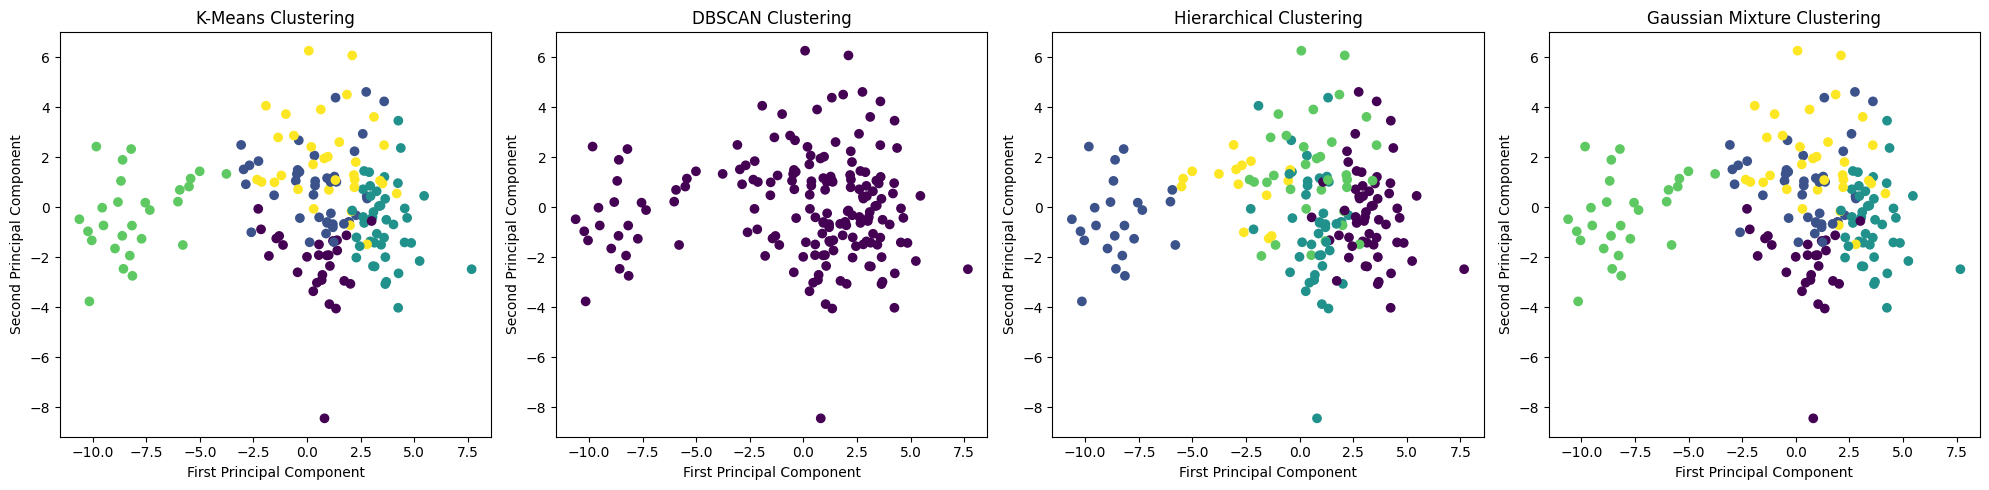

In [10]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Prepare data (using existing X from previous code)
clustering_methods = {
    'K-Means': KMeans(n_clusters=5, random_state=42),
    'DBSCAN': DBSCAN(eps=2.5, min_samples=3),
    'Hierarchical': AgglomerativeClustering(n_clusters=5),
    'Gaussian Mixture': GaussianMixture(n_components=5, random_state=42)
}

# Compare clustering methods
plt.figure(figsize=(20, 5))
for idx, (name, model) in enumerate(clustering_methods.items(), 1):
    plt.subplot(1, 4, idx)
    
    # Fit the model
    if name == 'Gaussian Mixture':
        labels = model.fit_predict(X)
    else:
        labels = model.fit_predict(X)
    
    # Calculate silhouette score (except for DBSCAN which might have -1 labels)
    if name != 'DBSCAN':
        score = silhouette_score(X, labels)
        print(f"{name} Silhouette Score: {score:.3f}")
    
    # Plot first two PCA components colored by cluster
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.title(f'{name} Clustering')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')

plt.tight_layout()
plt.show()

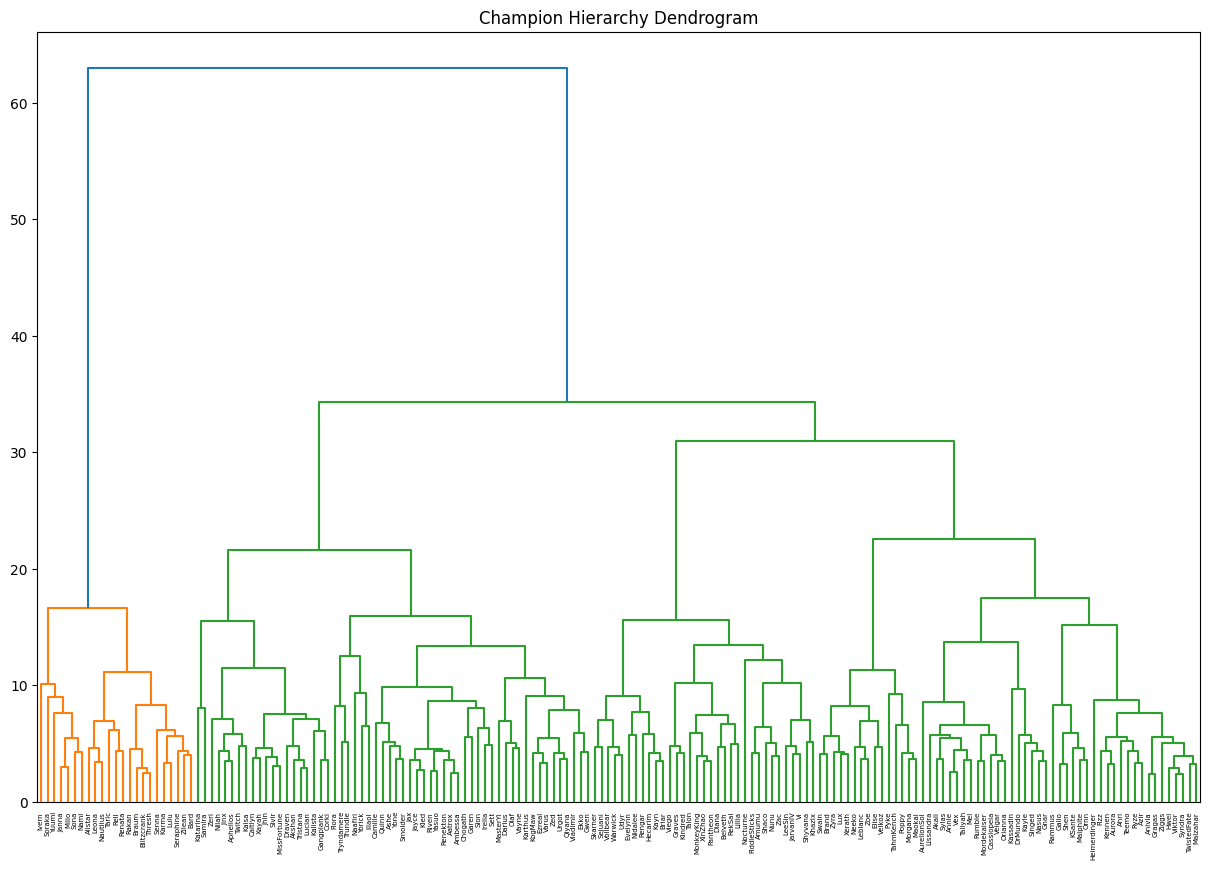


Most Hybrid Champions (highest mixture of playstyles):
       Champion  Hybrid Score
0         Annie -1.000000e-10
1          Olaf -1.000000e-10
2         Galio -1.000000e-10
3   TwistedFate -1.000000e-10
4       XinZhao -1.000000e-10
5         Urgot -1.000000e-10
6       Leblanc -1.000000e-10
7      Vladimir -1.000000e-10
8  FiddleSticks -1.000000e-10
9         Kayle -1.000000e-10


In [11]:
# For Hierarchical Clustering, show dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(15, 10))
linkage_matrix = linkage(X, 'ward')
dendrogram(linkage_matrix, labels=df['championName'].values)
plt.title('Champion Hierarchy Dendrogram')
plt.xticks(rotation=90)
plt.show()

# For Gaussian Mixture, show probability distribution
if 'Gaussian Mixture' in clustering_methods:
    gmm = clustering_methods['Gaussian Mixture']
    probs = gmm.predict_proba(X)
    
    # Show champions with highest mixture of playstyles
    hybrid_scores = -np.sum(probs * np.log(probs + 1e-10), axis=1)  # entropy
    most_hybrid = pd.DataFrame({
        'Champion': df['championName'],
        'Hybrid Score': hybrid_scores
    }).sort_values('Hybrid Score', ascending=False)
    
    print("\nMost Hybrid Champions (highest mixture of playstyles):")
    print(most_hybrid.head(10))